# Total Correation with Iterative Gaussianization

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library functions

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

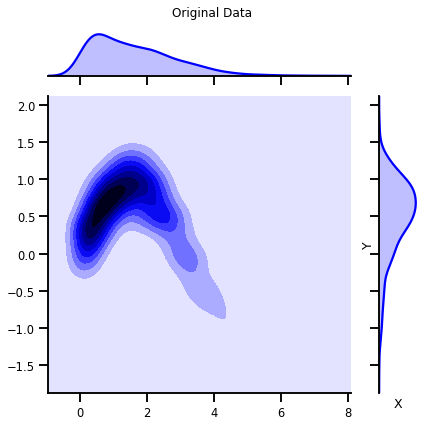

In [2]:
# %%wandb
# get data
data = get_classic(100_000)

# plot data
plot_joint(data[:1_000], "blue", "Original Data", kind='kde', logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

## Total Correlation

#### Toy Data

In [3]:
from sklearn.utils import check_random_state

#Parameters
n_samples = 10_000
d_dimensions = 30

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

# covariance matrix
C = A.T @ A
vv = onp.diag(C)

# closed Form
tc_original = onp.log(onp.sqrt(vv)).sum() - 0.5 * onp.log(onp.linalg.det(C))

print(f"TC: {tc_original:.4f}")

TC: 35.2632


### RBIG Estimator

In [4]:
from rbig_jax.information.entropy import histogram_entropy
from rbig_jax.transforms.histogram import histogram_transform
from rbig_jax.information.total_corr import rbig_total_correlation

#### Marginal Uniformization

In [5]:
from rbig_jax.transforms.histogram import get_hist_params

support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(data.shape[0]))
return_params = False

uniformize_transform = jax.partial(
    get_hist_params,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha,
    return_params=return_params
)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


#### Univariate Entropy

In [6]:
# define marginal entropy function
entropy_f = jax.partial(histogram_entropy, nbins=1_000, base=2)

## TC w. Scan Function

In [7]:
%%time
n_iterations = 20
p = 0.1

X_trans, loss = rbig_total_correlation(
    np.array(data), 
    marginal_uni=uniformize_transform, 
    uni_entropy=entropy_f, 
    n_iterations=n_iterations,
    p=p
)

CPU times: user 5.17 s, sys: 45.2 ms, total: 5.21 s
Wall time: 5.2 s


In [8]:
%%time
total_corr = np.sum(loss) * np.log(2)

CPU times: user 130 ms, sys: 18.7 ms, total: 149 ms
Wall time: 20.3 ms


In [9]:
%%time

print(f"Estimated TC: {total_corr:.4f}")

Estimated TC: 34.8091
CPU times: user 31.7 s, sys: 1min 40s, total: 2min 11s
Wall time: 2.51 s


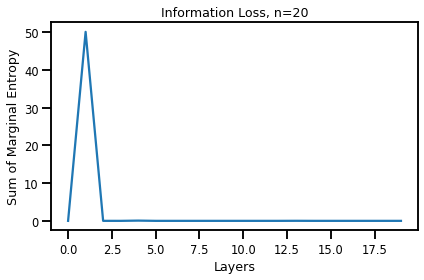

In [10]:
plot_info_loss(loss, n_layers=len(loss))